In [17]:
import pandas as pd
import keras
from keras.models import Sequential,Model
from keras.layers import Dense, Dropout, BatchNormalization,Input
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import regularizers,initializers
from keras.layers import GaussianNoise,LeakyReLU
import keras.backend as Kb

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.utils import class_weight
import numpy as np
from numpy import exp
# Library for Gaussian process
# import GPy
##Library for visualization
import matplotlib.pyplot as plt
# get_ipython().run_line_magic('matplotlib', 'inline')
# get_ipython().run_line_magic('config', "InlineBackend.figure_format = 'svg'")
import matplotlib;matplotlib.rcParams['figure.figsize'] = (8,6)
import pylab 
import time
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [18]:
### Shapley values library

import shap

In [19]:
### Importing dataset

df_loc = pd.read_csv("../../synthetic_data_simulations_nonGaussian_cov/2d_nongaussian_1200_1.csv", 
                             sep = ",")
df_train,df_test = train_test_split(df_loc, test_size = 0.1, random_state=123)
df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
# df_train1 = df_train.copy()
N = len(df_train)
s = np.vstack((df_train["x"],df_train["y"])).T
variance_var1 = np.var(df_train["var1"])
variance_var2 = np.var(df_train["var2"])
mean_var1 = np.mean(df_train["var1"])
mean_var2 = np.mean(df_train["var2"])
df_train["var1"] = (df_train["var1"] - mean_var1)/np.sqrt(variance_var1)
df_train["var2"] = (df_train["var2"] - mean_var2)/np.sqrt(variance_var2)
y = np.array(df_train[["var1","var2"]])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [58]:
### Basis functions

num_basis = [2**2,4**2,5**2]
knots_1d = [np.linspace(0,1,int(np.sqrt(i))) for i in num_basis]
##Wendland kernel
K = 0
phi = np.zeros((N, sum(num_basis)))

for res in range(len(num_basis)):
    theta = 1/np.sqrt(num_basis[res])*2.5
    knots_s1, knots_s2 = np.meshgrid(knots_1d[res],knots_1d[res])
    knots = np.column_stack((knots_s1.flatten(),knots_s2.flatten()))
    for i in range(num_basis[res]):
        d = np.linalg.norm(s-knots[i,:],axis=1)/theta
        for j in range(len(d)):
            if d[j] >= 0 and d[j] <= 1:
                phi[j,i + K] = (1-d[j])**6 * (35 * d[j]**2 + 18 * d[j] + 3)/3
            else:
                phi[j,i + K] = 0
    K = K + num_basis[res]
covariates_train = np.array(df_train[["cov1","cov2",
                                     "cov3","cov4",
                                     "cov5"]])
scaler = MinMaxScaler()
scaler.fit(covariates_train)
covariates_train = scaler.transform(covariates_train)
covariates = pd.DataFrame(covariates_train, columns=['covariate 1', 'covariate 2', 'covariate 3',
                                                    'covariate 4','covariate 5'])

In [52]:
### Load the model from prediction file

def model_function(phi,y,covariate = False):
   
    
    def custom_mse(y_true, y_pred):

        # calculating squared difference between target and predicted values 
        loss = Kb.square(y_pred - y_true)  # (batch_size, 2)

        # multiplying the values with weights along batch dimension
        loss = loss * [(1/variance_var1), (1/variance_var2)]          # (batch_size, 2)

        # summing both loss values along batch dimension 
        loss = Kb.sum(loss, axis=1)        # (batch_size,)

        return loss

    model = Sequential()

    model.add(Dense(100, input_dim = phi.shape[1],  
                kernel_initializer='he_uniform', activation='linear'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(100, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(100, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(100, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(100, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))

    model.add(Dense(50, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    model.add(Dense(50, activation='linear'))
    model.add(LeakyReLU(alpha=0.1))
    if covariate == True: model.add(Dense(1, activation='linear'))
    else: model.add(Dense(2, activation='linear'))
        
    
    
    optimizer = keras.optimizers.Adam(lr=0.001)
    model.compile(optimizer=optimizer, loss= 'mse', metrics=['mae','mse'])
    print('<<<<<<<<<<<<<<<< Fitting DNN-model >>>>>>>>>>>>>>>>>')
    result = model.fit(phi, y, 
                       epochs = 1000, batch_size = 512, verbose = 0)
    
    callbacks = [EarlyStopping(monitor='val_loss', patience=40),
                 ModelCheckpoint(filepath='Biv_nonGaussian_model.h5', monitor='val_loss', save_best_only=True)]
    result = model.fit(phi, y, callbacks=callbacks, 
                       validation_split = 0.1, epochs = 250, batch_size = 512, verbose = 0)
    model = keras.models.load_model('Biv_nonGaussian_model.h5')
    return model

In [53]:
### Run the model with basis functions first 

model1 = model_function(phi,y,False)

<<<<<<<<<<<<<<<< Fitting DNN-model >>>>>>>>>>>>>>>>>


In [54]:
### Run the model with covariates on the residual 

resi_y = np.zeros((len(y),2))
y_pred = model1.predict(phi)
resi_y[:,0] = y[:,0] - y_pred[:,0]
resi_y[:,1] = y[:,1] - y_pred[:,1]

model2_var1 = model_function(covariates_train,resi_y[:,0],True)
model2_var2 = model_function(covariates_train,resi_y[:,1],True)

<<<<<<<<<<<<<<<< Fitting DNN-model >>>>>>>>>>>>>>>>>
<<<<<<<<<<<<<<<< Fitting DNN-model >>>>>>>>>>>>>>>>>


In [132]:
def f(X):
    return model2_var1.predict(X).flatten()

In [141]:
f(covariates)

array([ 0.12439251,  0.02603069, -0.11484823, ..., -0.44161928,
        0.00656256, -0.13992743], dtype=float32)

In [100]:
X100 = shap.utils.sample(covariates, 100) # 100 instances for use as the background distribution

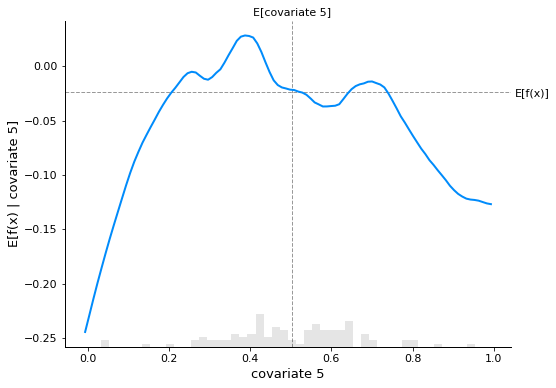

In [112]:
shap.partial_dependence_plot(
    "covariate 5",
    model2_var1.predict,
    X100,
    ice=False,
    model_expected_value=True,
    feature_expected_value=True,
)

In [134]:
### Shapley value computations for variable 1

explainer = shap.Explainer(f, X100)
shap_values = explainer(covariates)

Exact explainer: 1081it [02:17,  7.30it/s]                          


In [135]:
shap_values[15]

.values =
array([ 0.00700741,  0.01487658,  0.09775267, -0.01011237,  0.00579173])

.base_values =
-0.023661882262676955

.data =
array([0.61156586, 0.30536939, 0.46466514, 0.50483143, 0.68894801])

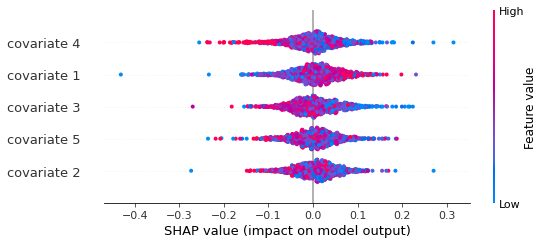

In [136]:
shap.summary_plot(shap_values, covariates)

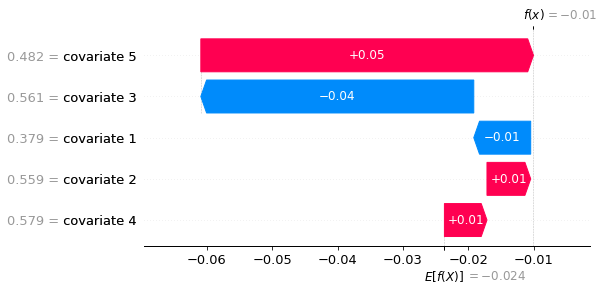

In [139]:
shap.waterfall_plot(shap_values[35], max_display=14)

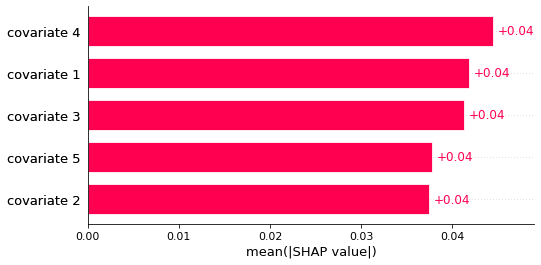

In [140]:
shap.plots.bar(shap_values)